In [1]:
import pymc3 as pm 
import matplotlib.pyplot as plt
import numpy as np 
import theano
import theano.tensor as tt
from scipy import stats
import pymc3 as pm 
from ipynb.fs.full.simul_data import *
from ipynb.fs.full.counterfactual_generate import *
K=7
mu_mult = np.zeros(K)
cov_mult = np.eye(K)

In [2]:
num_samples =100
causal_model = model1()
data = causal_model.generate(num_samples)
print(data["transcript"].shape)
# mu_rand = np.random.normal(size=10)

(100,)


In [3]:
def model_fit(data,method='mcmc'):

    with pm.Model() as model:

        #prior sampling
        u = pm.Normal('u',mu=0,tau=1)
        transcript0 = pm.Normal('transcript0',mu=0,tau=1)
        view0 = pm.Normal('view0',mu=0,tau=1)

        #effect of u 
        eta_u_transcript = pm.Normal('eta_u_transcript',mu=0,tau=1)
        eta_u_view = pm.Normal('eta_u_view',mu=0,tau=1)
        eta_u_rating = pm.Normal('eta_u_rating',mu=0,tau=1)

        #effect of protected attribute
        eta_a_transcript = pm.MvNormal('eta_a_transcript',mu=mu_mult,cov=cov_mult,shape=K)
        eta_a_view = pm.MvNormal('eta_a_view',mu=mu_mult,cov=cov_mult,shape=K)
        eta_a_rating = pm.MvNormal('eta_a_rating',mu=mu_mult,cov=cov_mult,shape=K)

        #effect of transcript on view and rating
        eta_transcript_view = pm.Normal('eta_transcript_view',mu=0,tau=1)
        eta_transcript_rating = pm.Normal('eta_transcript_rating',mu=0,tau=1)

        #effect of view on rating
        eta_view_rating = pm.Normal('eta_view_rating',mu=0,tau=1)


        sigma_transcript_sq = pm.InverseGamma('sigma_transcript_sq',alpha=1,beta=1)
        sigma_rating_sq = pm.InverseGamma('sigma_rating_sq',alpha=1,beta=1)

        transcript_mean = transcript0 + eta_u_transcript * u + tt.dot(data['a'] , eta_a_transcript)
        print(transcript_mean.shape)
        transcript = pm.Normal('transcript', mu= transcript_mean, sd = sigma_transcript_sq, observed = data["transcript"] )

        view_mean = tt.exp(view0 + eta_u_view * u +  transcript * eta_transcript_view + tt.dot(data['a'],eta_a_view))
        view = pm.Poisson('view',mu =view_mean, observed = data['view'] )

        rating_mean = eta_u_rating * u +  tt.dot(data['a'],eta_a_rating) + transcript* eta_transcript_rating + view* eta_view_rating 
        rating = pm.Normal('rating', mu= rating_mean, sd = sigma_rating_sq, observed = data["rating"] ) 
        
        if method == 'mcmc':        
            trace=pm.sample(1000)
        elif method == 'vi':
            trace=pm.fit()
        else:
            print('Go Fuck Yourself')
            
    return trace
    

In [4]:
trace = model_fit(data)

Shape.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_rating_sq, sigma_transcript_sq, eta_view_rating, eta_transcript_rating, eta_transcript_view, eta_a_rating, eta_a_view, eta_a_transcript, eta_u_rating, eta_u_view, eta_u_transcript, view0, transcript0, u]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:55<00:00, 26.01draws/s]
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


In [5]:
trace["eta_view_rating"].mean(axis=0)

-0.43406932443827295

In [6]:
u_list = counterfactual_sample(data,trace)

num_original_sample is  100


Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [u]
Sampling 2 chains: 100%|██████████| 1040/1040 [00:06<00:00, 164.13draws/s]
/Users/rupamacharyya/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c222f63c8>,
      dtype=object)

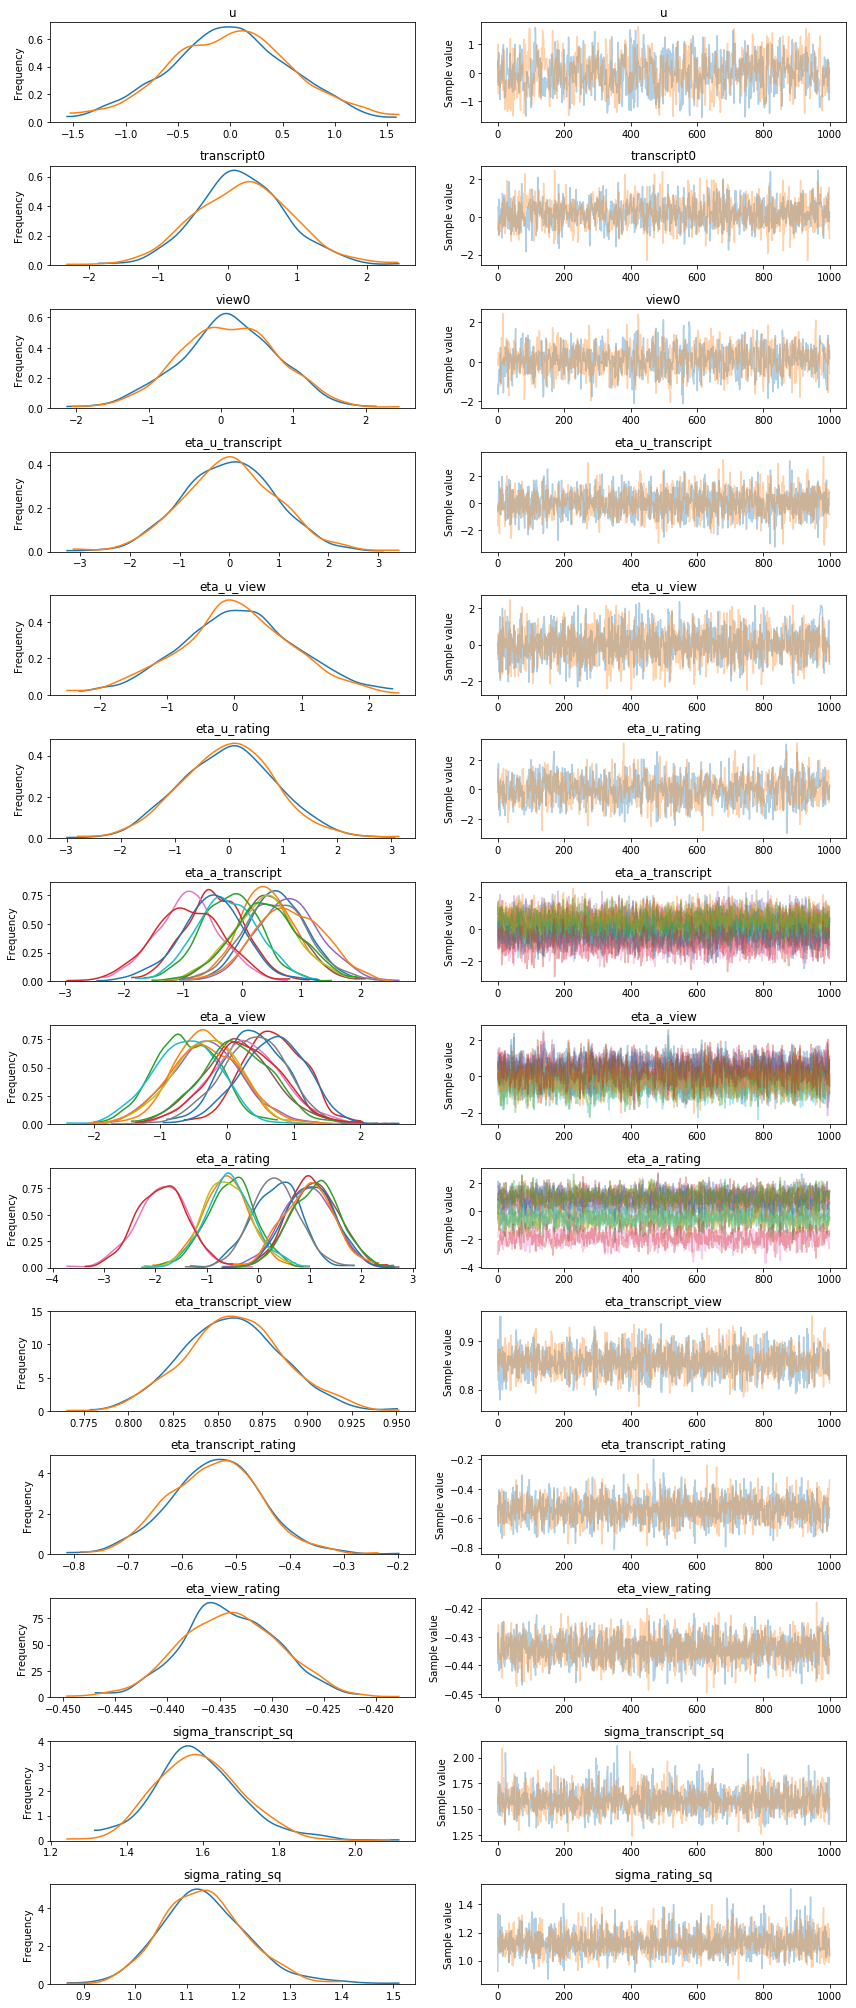

In [7]:
pm.traceplot(trace)

In [8]:
u_list.shape

(40, 100)